# 1. Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.calibration import calibration_curve

train = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv").drop(["id","Name"],axis =1) 
original = pd.read_csv("/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv").drop("Name",axis = 1)
original["Depression"] = original["Depression"].map({"No": 0, "Yes": 1})
train = pd.concat([train,original])
test = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv")
test = test.drop(["id","Name"],axis = 1)

object_columns = [col for col in train.columns if train[col].dtype == 'object']
encode_columns = object_columns + ["Academic Pressure", "Work Pressure", "Study Satisfaction", "Work/Study Hours", "Financial Stress","Job Satisfaction"]

for col in encode_columns:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

cat_features = encode_columns.copy()
del object_columns,encode_columns

X,y = train.drop("Depression",axis = 1).copy(),train.Depression.copy()

skf = StratifiedKFold(n_splits = 10,random_state = 42,shuffle = True)

# 2. LGBM Training

In [2]:
def train_lgbm(lgb_params, X,y,name):
    lgb_oof_preds = np.zeros(len(y))
    lgb_oof_probas = np.zeros(len(y))
    lgb_test_preds = np.zeros(len(test))
    lgb_test_probas = np.zeros(len(test))
    lgb_train_scores = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]
    
    
        lgb_train = lgb.Dataset(X_train, y_train, )
        lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

        model = lgb.train(
        lgb_params,
        lgb_train,
        valid_sets=[lgb_valid],
        callbacks=[lgb.early_stopping(stopping_rounds=30)],  
    )

        y_pred_proba = model.predict(X_valid, num_iteration=model.best_iteration)
        y_pred = (y_pred_proba > 0.5).astype(int)
        accuracy = accuracy_score(y_valid, y_pred)
        lgb_train_scores.append(accuracy)
    
        print("Fold:", fold, "Accuracy Score:", accuracy)
    
        y_test_probas = model.predict(test)
        y_test_preds = (y_test_probas > 0.5).astype(int)
    
        lgb_oof_preds[test_idx] = y_pred
        lgb_oof_probas[test_idx] = y_pred_proba
        lgb_test_probas += y_test_probas
        lgb_test_preds += y_test_preds

    lgb_test_probas /= skf.get_n_splits()
    lgb_test_preds /= skf.get_n_splits()

    oof_results = pd.DataFrame({f'{name}_lgb_oof_preds':lgb_oof_preds,
                          f'{name}_lgb_oof_probas':lgb_oof_probas})
    test_results = pd.DataFrame({
                          f'{name}_lgb_test_preds':lgb_test_preds,
                          f'{name}_lgb_test_probas':lgb_test_probas})
    return oof_results,test_results

In [3]:
gbdt_params = {'learning_rate': 0.015037382974893173,
                 'num_leaves': 143,
                 'max_bin': 448,
                 'reg_alpha': 0.00010623936018699637,
                 'reg_lambda': 5.420412044776439e-05,
                 'num_boost_round': 230,
                 'boosting_type': 'gbdt',
                 'objective': 'binary',
                 'random_state': 42,
                 'is_unbalance': True,
                 'metric': 'auc'}
gbdt_lgbm_oof_results, gbdt_lgbm_test_results= train_lgbm(gbdt_params, X, y,'gbdt')

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181649 -> initscore=-1.505215
[LightGBM] [Info] Start training from score -1.505215
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[230]	valid_0's auc: 0.972924
Fold: 0 Accuracy Score: 0.9185397179952534


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181649 -> initscore=-1.505215
[LightGBM] [Info] Start training from score -1.505215
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[230]	valid_0's auc: 0.972166
Fold: 1 Accuracy Score: 0.9215412536646657


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181649 -> initscore=-1.505215
[LightGBM] [Info] Start training from score -1.505215
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[230]	valid_0's auc: 0.971576
Fold: 2 Accuracy Score: 0.9204244031830239


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181649 -> initscore=-1.505215
[LightGBM] [Info] Start training from score -1.505215
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[230]	valid_0's auc: 0.971906
Fold: 3 Accuracy Score: 0.9183303085299456


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23419, number of negative: 105511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181641 -> initscore=-1.505268
[LightGBM] [Info] Start training from score -1.505268
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[230]	valid_0's auc: 0.976464
Fold: 4 Accuracy Score: 0.9219600725952813


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23419, number of negative: 105511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181641 -> initscore=-1.505268
[LightGBM] [Info] Start training from score -1.505268
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[229]	valid_0's auc: 0.973047
Fold: 5 Accuracy Score: 0.9225184978361022


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 128931, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181648 -> initscore=-1.505225
[LightGBM] [Info] Start training from score -1.505225
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[230]	valid_0's auc: 0.972476
Fold: 6 Accuracy Score: 0.9208376963350785


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 128931, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181648 -> initscore=-1.505225
[LightGBM] [Info] Start training from score -1.505225
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[230]	valid_0's auc: 0.972249
Fold: 7 Accuracy Score: 0.9185340314136126


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 128931, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181648 -> initscore=-1.505225
[LightGBM] [Info] Start training from score -1.505225
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[230]	valid_0's auc: 0.974965
Fold: 8 Accuracy Score: 0.9198603839441536


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 128931, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181648 -> initscore=-1.505225
[LightGBM] [Info] Start training from score -1.505225
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[230]	valid_0's auc: 0.973171
Fold: 9 Accuracy Score: 0.9202094240837696


In [4]:
dart_params = {'learning_rate': 0.012218076940371136,
 'num_leaves': 103,
 'max_bin': 352,
 'reg_alpha': 0.02678314325645604,
 'reg_lambda': 1.537637211049306,
 'num_boost_round': 210,
 'boosting_type': 'dart',
 'objective': 'binary',
 'random_state': 42,
 'is_unbalance': True,
 'metric': 'auc'}
dart_lgbm_oof_results, dart_lgbm_test_results= train_lgbm(dart_params, X, y,'dart')

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181649 -> initscore=-1.505215
[LightGBM] [Info] Start training from score -1.505215


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


Fold: 0 Accuracy Score: 0.917353064358509


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181649 -> initscore=-1.505215
[LightGBM] [Info] Start training from score -1.505215


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


Fold: 1 Accuracy Score: 0.9228675136116152


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181649 -> initscore=-1.505215
[LightGBM] [Info] Start training from score -1.505215


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


Fold: 2 Accuracy Score: 0.9202149937177161


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181649 -> initscore=-1.505215
[LightGBM] [Info] Start training from score -1.505215


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


Fold: 3 Accuracy Score: 0.9170738517380985


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23419, number of negative: 105511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181641 -> initscore=-1.505268
[LightGBM] [Info] Start training from score -1.505268


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


Fold: 4 Accuracy Score: 0.9223788915258969


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23419, number of negative: 105511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181641 -> initscore=-1.505268
[LightGBM] [Info] Start training from score -1.505268


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


Fold: 5 Accuracy Score: 0.9219600725952813


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 128931, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181648 -> initscore=-1.505225
[LightGBM] [Info] Start training from score -1.505225


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


Fold: 6 Accuracy Score: 0.9208376963350785


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 128931, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181648 -> initscore=-1.505225
[LightGBM] [Info] Start training from score -1.505225


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


Fold: 7 Accuracy Score: 0.9171378708551483


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 128931, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181648 -> initscore=-1.505225
[LightGBM] [Info] Start training from score -1.505225


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


Fold: 8 Accuracy Score: 0.9211169284467714


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 128931, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181648 -> initscore=-1.505225
[LightGBM] [Info] Start training from score -1.505225


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


Fold: 9 Accuracy Score: 0.920977312390925


In [5]:
rf_params = {'learning_rate': 0.00012354203662305,
 'num_leaves': 111,
 'max_bin': 128,
 'reg_alpha': 0.002167842399350645,
 'reg_lambda': 3.5522822496011746e-06,
 'num_boost_round': 250,
 'boosting_type': 'rf',
 'objective': 'binary',
 'random_state': 42,
 'is_unbalance': True,
'bagging_fraction': 0.8,  
        'bagging_freq': 1, 
 'metric': 'auc'}
rf_lgbm_oof_results, rf_lgbm_test_results= train_lgbm(rf_params, X, y,'rf')

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181649 -> initscore=-1.505215
[LightGBM] [Info] Start training from score -1.505215
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 0.962144
Fold: 0 Accuracy Score: 0.8911070780399274


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181649 -> initscore=-1.505215
[LightGBM] [Info] Start training from score -1.505215
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[141]	valid_0's auc: 0.9626
Fold: 1 Accuracy Score: 0.8984364093257016


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181649 -> initscore=-1.505215
[LightGBM] [Info] Start training from score -1.505215
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.960894
Fold: 2 Accuracy Score: 0.8928521569174926


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 356
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181649 -> initscore=-1.505215
[LightGBM] [Info] Start training from score -1.505215
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's auc: 0.962984
Fold: 3 Accuracy Score: 0.893340779003211


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23419, number of negative: 105511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181641 -> initscore=-1.505268
[LightGBM] [Info] Start training from score -1.505268
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[89]	valid_0's auc: 0.96506
Fold: 4 Accuracy Score: 0.8939690073991344


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23419, number of negative: 105511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 128930, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181641 -> initscore=-1.505268
[LightGBM] [Info] Start training from score -1.505268
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.963863
Fold: 5 Accuracy Score: 0.8960631020522127


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 128931, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181648 -> initscore=-1.505225
[LightGBM] [Info] Start training from score -1.505225
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[83]	valid_0's auc: 0.964294
Fold: 6 Accuracy Score: 0.8955671902268761


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 128931, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181648 -> initscore=-1.505225
[LightGBM] [Info] Start training from score -1.505225
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's auc: 0.959749
Fold: 7 Accuracy Score: 0.8883071553228621


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 128931, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181648 -> initscore=-1.505225
[LightGBM] [Info] Start training from score -1.505225
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[127]	valid_0's auc: 0.963838
Fold: 8 Accuracy Score: 0.89521815008726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23420, number of negative: 105511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 128931, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181648 -> initscore=-1.505225
[LightGBM] [Info] Start training from score -1.505225
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[83]	valid_0's auc: 0.965065
Fold: 9 Accuracy Score: 0.8960558464223386


# 3. Predictions Over Probas

In [6]:
lgbm_oof_results = pd.concat([gbdt_lgbm_oof_results,
                        dart_lgbm_oof_results,
                        rf_lgbm_oof_results,
                        y.reset_index(drop = True)],axis = 1)

lgbm_test_results = pd.concat([gbdt_lgbm_test_results,
                         dart_lgbm_test_results,
                         rf_lgbm_test_results],axis=1)

# lgbm_oof_results.to_csv("lgbm_oof_results.csv", index = False)
# lgbm_test_results.to_csv("lgbm_test_results.csv",index = False)

In [7]:
def plot_calibration(column):
    prob_true, prob_pred = calibration_curve(y_true=y,y_prob=lgbm_oof_results[column])
    plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Ideal')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('gbdt_lgb_oof_probas')
    plt.legend()
    plt.show()

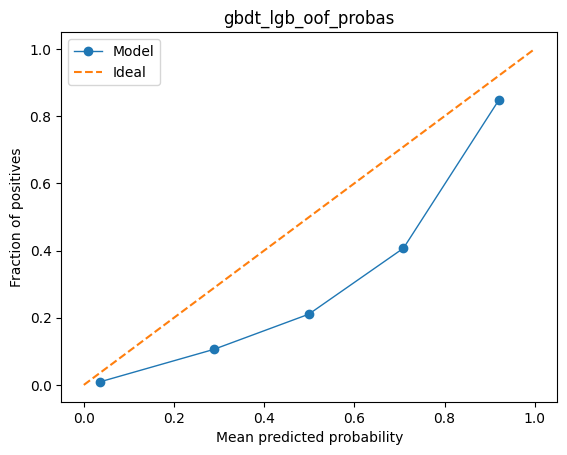

In [8]:
plot_calibration("gbdt_lgb_oof_probas")

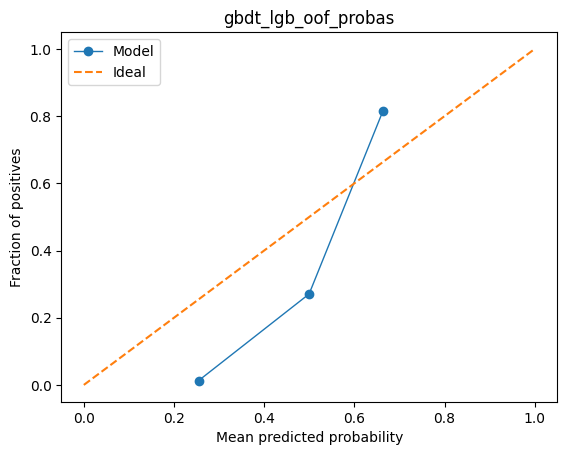

In [9]:
plot_calibration("dart_lgb_oof_probas")

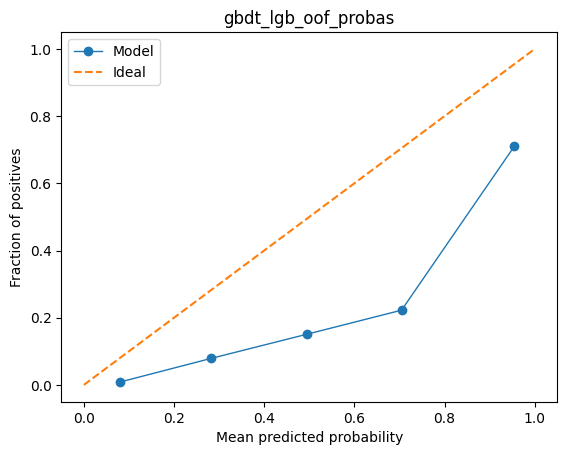

In [10]:
plot_calibration("rf_lgb_oof_probas")

In [11]:
X_meta_train = lgbm_oof_results[["gbdt_lgb_oof_probas",
                          "dart_lgb_oof_probas",
                          "rf_lgb_oof_probas"]].copy()
X_meta_test = lgbm_test_results.iloc[:,[1,3,5]].copy()
y_meta_train = y.copy()

logit = LogisticRegression(random_state = 42)
logit.fit(X_meta_train.values,y_meta_train)
y_pred = logit.predict(X_meta_test.values)
submission = pd.DataFrame({'id': range(140700,140700+len(test)),
                          "Depression": y_pred}).set_index("id")
submission.to_csv("submission.csv")

In [12]:
from sklearn.calibration import CalibratedClassifierCV
X_train,X_test,y_train,y_test = train_test_split(X_meta_train.values,y_meta_train.values,random_state = 42,
                                                stratify = y_meta_train.values)
calibrated_model = CalibratedClassifierCV(base_estimator = logit,cv = 3)
calibrated_model.fit(X_train,y_train)
y_pred = calibrated_model.predict_proba(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


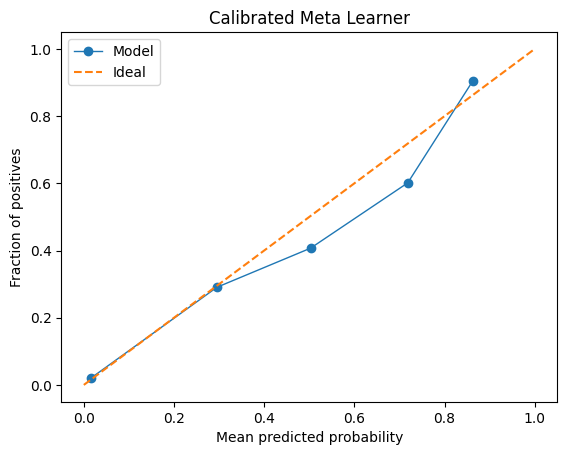

In [13]:
prob_true, prob_pred = calibration_curve(y_true=y_test,y_prob=y_pred[:,1])
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Ideal')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibrated Meta Learner')
plt.legend()
plt.show()

In [14]:
y_pred = calibrated_model.predict(X_meta_test.values)
submission = pd.DataFrame({'id': range(140700,140700+len(test)),
                          "Depression": y_pred}).set_index("id")
submission.to_csv("sub.csv")